In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import librosa, librosa.display
from IPython import display
import tensorflow as tf
from keras.utils import to_categorical
display.set_matplotlib_formats('svg')
import os
from sklearn.utils import resample
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
import IPython.display as ipd
from sklearn.model_selection import train_test_split

2023-04-20 12:31:47.431223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 12:31:47.597504: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/tmp/ipykernel_4601/3318507464.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
df = pd.read_csv("dataset/set_b.csv")
df.head()

dataset                                              fname       label  \
0       b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1       b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2       b  set_b/Btraining_extrastole_130_1306347376079_D...  extrastole   
3       b  set_b/Btraining_extrastole_134_1306428161797_C...  extrastole   
4       b  set_b/Btraining_extrastole_138_1306762146980_B...  extrastole   

  sublabel  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [3]:
len(df['fname'])

656

<Axes: >

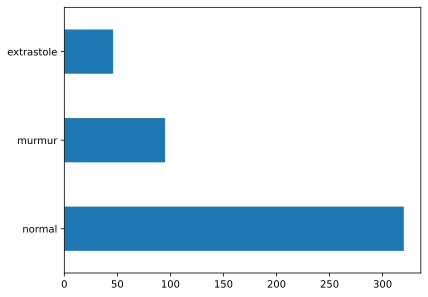

In [4]:
y = df["label"]
y.value_counts().plot(kind="barh")

murmur = 3x less than normal, extrastole = 6x
Upsampling for extrastole + murmur may be needed

<Axes: >

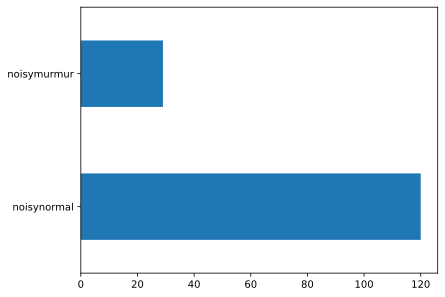

In [5]:
sublabel = df["sublabel"]
sublabel.value_counts().plot(kind="barh")

Visualize soundwaves in its raw form

In [6]:
normal_sample = "dataset/set_b/normal_103_1305031931979_B.wav"
murmur_sample = "dataset/set_b/murmur_112_1306243000964_A.wav"
extrast_sample = "dataset/set_b/extrastole_274_1311075637574_A.wav"

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(12,8))
normal_sn, normal_sr = librosa.load(normal_sample, sr=22050)
normal_soundwave = librosa.display.waveshow(normal_sn, sr=normal_sr, ax=ax[0])
ax[0].set_title("Normal")
ax[0].set_xlabel("Time (seconds)")
ax[0].set_ylabel("Amplitude")
ax[0].label_outer()

murmur_sn, murmur_sr = librosa.load(murmur_sample, sr=22050)
murmur_soundwave = librosa.display.waveshow(murmur_sn, sr=murmur_sr, ax=ax[1])
ax[1].set_title("Murmur")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("Amplitude")
ax[1].label_outer()

extrast_sn, extrast_sr = librosa.load(extrast_sample, sr=22050)
extrast_soundwave = librosa.display.waveshow(extrast_sn, sr=extrast_sr, ax=ax[2])
ax[2].set_title("Extrastole")
ax[2].set_xlabel("Time (seconds)")
ax[2].set_ylabel("Amplitude")
ax[2].label_outer()

In [7]:
ipd.Audio(normal_sn, rate=normal_sr)

In [8]:
df.isnull().sum()

dataset       0
fname         0
label       195
sublabel    507
dtype: int64

"dataset" aned "sublabel" seems to be irrelevant as we're doing a classification with "label" as our y_train. Therefore we eliminate "sublabel" and "dataset"

In [9]:
df = df.drop(["dataset", "sublabel"], axis=1)
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

fname    0
label    0
dtype: int64

<h2>Replacing text with numerical values to prepare for one-hot encoding</h2>

In [11]:
df['label'] = df['label'].map({'normal': 0, 'murmur': 1, 'extrastole': 2})

<h3>The filenames are not the same as the actual audio filenames. Therefore we edit each label to access the "dataset/" dir first. Then delete "Btraining_" as it is not present in the audio </h3>

In [12]:
df = df.reset_index()
df = df.drop(["index"], axis=1)
df.head()

fname  label
0  set_b/Btraining_extrastole_127_1306764300147_C...      2
1  set_b/Btraining_extrastole_128_1306344005749_A...      2
2  set_b/Btraining_extrastole_130_1306347376079_D...      2
3  set_b/Btraining_extrastole_134_1306428161797_C...      2
4  set_b/Btraining_extrastole_138_1306762146980_B...      2

In [13]:
for index, fname in tqdm(enumerate(df['fname'])):
    if fname.startswith("Bunlabelledtest"):
        df.drop(index, inplace=True)
    else:
        df['fname'][index] = "dataset/" + fname.replace("Btraining_", "")
df.head()

0it [00:00, ?it/s]/tmp/ipykernel_4601/1963377133.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fname'][index] = "dataset/" + fname.replace("Btraining_", "")
461it [00:00, 7986.58it/s]


fname  label
0  dataset/set_b/extrastole_127_1306764300147_C2.wav      2
1   dataset/set_b/extrastole_128_1306344005749_A.wav      2
2   dataset/set_b/extrastole_130_1306347376079_D.wav      2
3  dataset/set_b/extrastole_134_1306428161797_C1.wav      2
4   dataset/set_b/extrastole_138_1306762146980_B.wav      2

In [14]:
df.head()

fname  label
0  dataset/set_b/extrastole_127_1306764300147_C2.wav      2
1   dataset/set_b/extrastole_128_1306344005749_A.wav      2
2   dataset/set_b/extrastole_130_1306347376079_D.wav      2
3  dataset/set_b/extrastole_134_1306428161797_C1.wav      2
4   dataset/set_b/extrastole_138_1306762146980_B.wav      2

In [15]:
os.chdir("dataset/set_b/")

In [16]:
fnames = os.listdir()
for fname in fnames:
    if "__" in fname:
        os.rename(fname, fname.replace("__", "_"))

In [17]:
df.label.value_counts()

0    320
1     95
2     46
Name: label, dtype: int64

<h3>Prepare Data for Upsampling</h3>
Upscale murmur and extrastole to the amount of normal samples

In [18]:
df_normal = df.loc[df['label'] == 0]
df_murmur = df.loc[df['label'] == 1]
df_extrastole = df.loc[df['label'] == 2]

In [19]:
x_murmur_upsampled = resample(df_murmur, n_samples=df_normal.shape[0], random_state=123)
x_extrastole_upsampled = resample(df_extrastole, n_samples=df_normal.shape[0], random_state=123)

In [20]:
df_final = pd.concat([df_normal, x_murmur_upsampled, x_extrastole_upsampled])

In [21]:
df_final = df_final.reset_index()
df_final = df_final.drop(["index"], axis=1)
df_final.head()

fname  label
0   dataset/set_b/normal_103_1305031931979_B.wav      0
1  dataset/set_b/normal_103_1305031931979_D1.wav      0
2  dataset/set_b/normal_103_1305031931979_D2.wav      0
3  dataset/set_b/normal_103_1305031931979_D3.wav      0
4  dataset/set_b/normal_106_1306776721273_B1.wav      0

<Axes: >

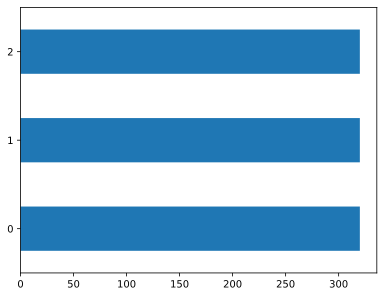

In [22]:
df_final.label.value_counts().plot(kind="barh")

In [23]:
os.chdir("..")
os.chdir("..")

<h3>Time frequency / Spectogram / MFCC visualization of audio</h3>

In [24]:
sample_signal, sr = librosa.load(df_final['fname'][0], sr=22050)

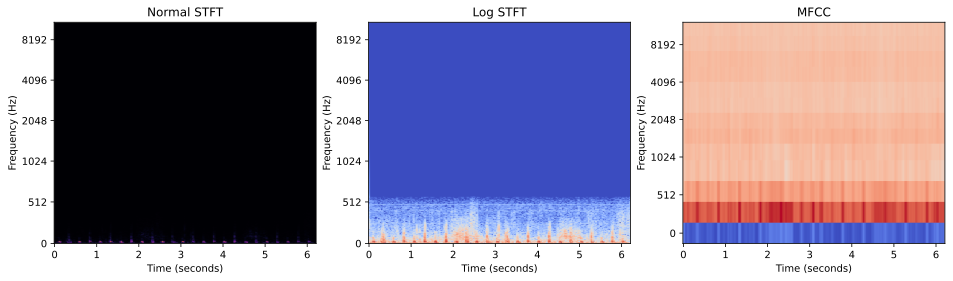

In [25]:

n_fft = 2048
hop_length = 512

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
stft = librosa.core.stft(sample_signal, n_fft=n_fft, hop_length=hop_length)
spectogram = np.abs(stft)
librosa.display.specshow(spectogram, sr=22050, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set_title("Normal STFT")
ax[0].set_xlabel("Time (seconds)")
ax[0].set_ylabel("Frequency (Hz)")
ax[0].label_outer()

log_spectogram = librosa.amplitude_to_db(spectogram)
librosa.display.specshow(log_spectogram, sr=22050, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax[1], n_fft=n_fft,)
ax[1].set_title("Log STFT")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("Frequency (Hz)")
ax[0].label_outer()

mfcc = librosa.feature.mfcc(y=np.array(sample_signal), sr=22050, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
librosa.display.specshow(mfcc, sr=22050, x_axis='time', y_axis='mel', ax=ax[2])
ax[2].set_title("MFCC")
ax[2].set_xlabel("Time (seconds)")
ax[2].set_ylabel("Frequency (Hz)")
ax[0].label_outer()

In [26]:
list1 = np.array([1,2,3])
list2 = np.array([4,5,6])
list1 * list2

array([ 4, 10, 18])

In [27]:
def load_audio(duraiton=15):
    data = []
    for filename in tqdm(df_final['fname']):
        signal, sr = librosa.load(filename, sr=22050)
        time = librosa.get_duration(y=signal, sr=sr)
        if round(time) < 10:
            audio = librosa.util.fix_length(signal, size=sr * duraiton, mode='wrap')
            mfccs = librosa.feature.mfcc(y=audio, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
        data.append(mfccs)
    return data

In [28]:
hello = np.array([1,2,3,4,5])
new_hello = librosa.util.fix_length(hello, size=10, mode='wrap')
new_hello

array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5])

In [29]:
x = load_audio(15)
y = to_categorical(df_final['label'], num_classes=3)

100%|██████████| 960/960 [00:07<00:00, 133.66it/s]


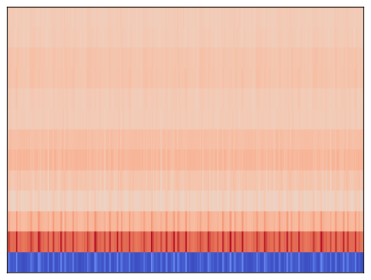

In [30]:
x = np.array(x)
y = np.array(y)
librosa.display.specshow(x[6])

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
x_train.shape

(768, 13, 646)

In [32]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train[0].shape

(13, 646, 1)

In [33]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=(13, 646, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-04-20 12:32:01.363490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 12:32:01.391940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 12:32:01.392093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 12:32:01.393382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 12:32:01.393510: I tensorflow/compiler/xla/stream_executo

In [34]:

history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
model.summary()

Epoch 1/50


2023-04-20 12:32:02.729783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-20 12:32:03.665574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-20 12:32:04.943557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 4s 15ms/step - loss: 1.2073 - accuracy: 0.6417 - val_loss: 36.5827 - val_accuracy: 0.3831
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.4058 - accuracy: 0.8436 - val_loss: 6.1691 - val_accuracy: 0.6039
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.1819 - accuracy: 0.9544 - val_loss: 6.6096 - val_accuracy: 0.6234
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0827 - accuracy: 0.9788 - val_loss: 4.0678 - val_accuracy: 0.6299
Epoch 5/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0839 - accuracy: 0.9821 - val_loss: 2.4707 - val_accuracy: 0.6299
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0592 - accuracy: 0.9837 - val_loss: 2.7037 - val_accuracy: 0.6364
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0375 - accuracy: 0.9951 - val_loss: 1.2303 - val_accuracy: 0.6948
Epoch 8/50
20/20 [===========

In [35]:
prd = model.predict(x_test)

6/6 [==============================] - 0s 1ms/step


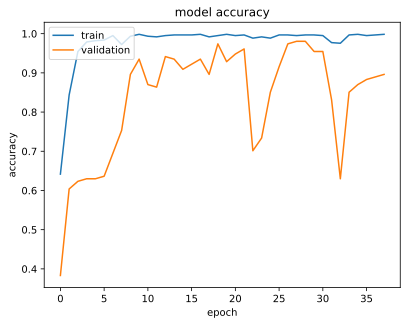

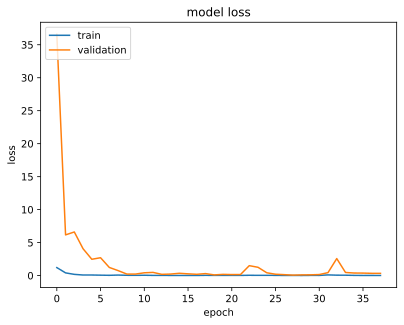

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
y_prd = prd.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [38]:
confusion_matrix(y_test, y_prd)

array([[55,  9,  9],
       [ 0, 57,  0],
       [ 0,  0, 62]])

<Axes: >

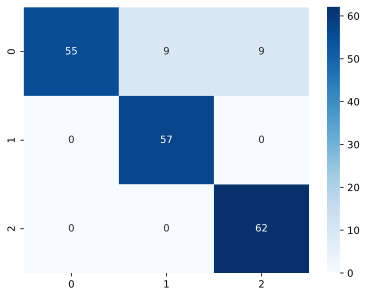

In [39]:
sns.heatmap(confusion_matrix(y_test, y_prd), annot=True, fmt='d', cmap='Blues')

In [40]:
print(classification_report(y_test, y_prd))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        73
           1       0.86      1.00      0.93        57
           2       0.87      1.00      0.93        62

    accuracy                           0.91       192
   macro avg       0.91      0.92      0.91       192
weighted avg       0.92      0.91      0.90       192

